In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg as la
from scipy import random as rnd
from scipy.special import gamma
import matplotlib.pyplot as plt
import cProfile

import cython
import numba
from numba import jit

#import bhc

#from bhc import helpfncs

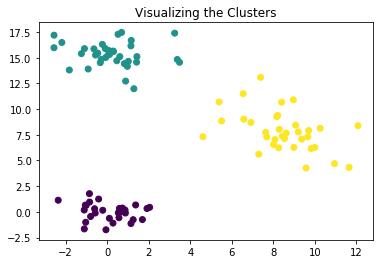

In [2]:
# bivariate gaussian params
mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([0, 15])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 7.5])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params
p1 = 0.3
p2 = 0.4
p3 = 1 - p2 - p1

# number of total draws
draws = 100


# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

# join columns into dataframe
x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "c" : c}
clustData = pd.DataFrame(dat)

plt.scatter(clustData["x1"], clustData["x2"], c = clustData["c"])
plt.title("Visualizing the Clusters")
plt.show()

In [ ]:
%load_ext Cython

In [47]:
%%cython -a

import cython

from functools import reduce
from scipy.special import gamma, loggamma
from scipy import stats
from scipy import linalg as la

import numpy as np
cimport numpy as np

from libc.math cimport exp, log

@cython.cdivision(True)
cdef double array_sum(double[:] x):
    """get sum of elements in array"""
    cdef double z = 0.0
    cdef unsigned int n, i
    n = x.shape[0]
    for i in range(n):
        z += x[i]
    return z

### hypothesis evaluation helper functions ###

@cython.boundscheck(False)
@cython.wraparound(False)
def norm_inv_wish_H1(ci, cj):
    """
    Evaluate hypothesis 1 for merging two clusters ci and cj.
    This function assumes MVTNormal-Wishart conjugacy.
    Will need to generalize later
    ci and cj - clusters being tested for merge
    
    Inv Wish prior hyperparams:
    v - df
    S - prior precision matrix (currently defined as empirical cov mat)
    
    Default Normal prior hyperparams:
    m - prior mean (currently defined as sample mean)
    r - scaling factor on the prior precision of the mean
    
    hkparams - dictionary of prior parameters (e.g.
    diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
    """

    # abbreviated keyword arguments for brevity in calcs
    cdef double[:, :] X = np.vstack([ci.clust, cj.clust])

    cdef double m = ci.priorParams["diffuseNormPrior"]["loc"]
    cdef double r = ci.priorParams["diffuseNormPrior"]["meanscale"]
    cdef unsigned int v = ci.priorParams["diffuseInvWishPrior"]["df"]
    cdef double [:, :] S = ci.priorParams["diffuseInvWishPrior"]["scale"]
    
    cdef unsigned int N, k
    N = X.shape[0]
    k = X.shape[1]
    
    # Specify Pi to several digits for comp efficiency
    cdef double PI = 3.1415926535897932384626433
    
    ## version of eval_H1 from Heller appendix

    # calc Xrowsum once for efficiency
    cdef double[:] Xrowsum, xrow
    cdef int i, j
    
    for i in range(N):
        Xrowsum[i] = array_sum(X[i, :])
        
    print(Xrowsum)
    
    
        
    #np.sum(X, axis = 0)
    
    # posterior precision matrix
    cdef double[:, :] Sprime = (
        np.dot(X.T, X) + (r * N / (N + r)) * np.dot(m, m.T) + 
        (1 / (N + r)) * np.dot(Xrowsum, Xrowsum.T) -
        (r / (N + r)) * (np.dot(m, Xrowsum.T) + np.dot(Xrowsum, m.T)) + S
    )

    cdef unsigned int vprime = v + N

    # components of p(D_k | H_1)
    cdef double[:] numarray = [loggamma((vprime + 1 - d) / 2) for d in range(1, k + 1)]
    #numer = reduce(lambda x, y: x * y, numer)
    cdef double numer = array_sum(numarray)
    cdef double[:] denarray = [loggamma((v + 1 - d) / 2) for d in range(1, k + 1)]
    #denom = reduce(lambda x, y: x * y, denom)
    cdef double denom = array_sum(denarray)
    
    cdef double logfact = (vprime * k / 2) * log(2) + numer - (v*k/2) * log(2) - denom
    
    
    MarginalLikelihood = (
        (-N * k / 2) * log(2 * PI) +
        (k / 2) * log(r / (N + r)) +
        (v / 2) * log(np.linalg.det(S)) +
        (-vprime / 2) * log(np.linalg.det(Sprime)) +
        logfact
    )
    
    return exp(MarginalLikelihood)


In [23]:

### hypothesis evaluation helper functions ###

def eval_H1(ci, cj):
    """
    Evaluate hypothesis 1 for merging two clusters ci and cj
    based on the family specified when HierarchyTree is
    initialized.

    ci and cj - clusters being tested for merge

    Inv Wish prior hyperparams:
    v - df
    S - prior precision matrix (currently defined as empirical cov mat)

    Default Normal prior hyperparams:
    m - prior mean (currently defined as sample mean)
    r - scaling factor on the prior precision of the mean

    hkparams - dictionary of prior parameters (e.g.
    diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
    """

    if ci.family == "norm-invwish":
        marginalLikelihood = norm_inv_wish_H1(ci, cj)
    elif ci.family == "beta-bern":
        pass

    return marginalLikelihood

###############################################################################


def eval_H2(ci, cj):
    """
    probability of hypothis 2: data comes from diff distr
    ci and cj - clusters being tested for merge
    """
    return ci.margLik * cj.margLik
    
###############################################################################


def prop_pi_k(ci, cj):
    """
    calculate the probability of merging cluster i and cluster j to create
    proposed cluster k
    ci and cj - clusters being tested for merge
    """

    # cluster size from proposed cluster k
    propClustSize = ci.clustsize + cj.clustsize

    # gamma fcn for the proposed cluster size 
    # calculating once for efficiency
    gammaPCS = gamma(propClustSize)

    # d_k for proposed cluster k
    if propClustSize == 2: # when joining two singletons
        propd = ci.alpha
    else:
        propd = (
        	ci.alpha *
            gammaPCS +
        	ci.d * cj.d
        	)

    # probability of creating proposed cluster k
    pik = ci.alpha * gammaPCS / propd

    return pik


###############################################################################


def marginal_clust_k(ci, cj):
    """
    calculate the marginal likelihood for cluster k
    This is the 'evidence' in Bayes Rule; called P(D_k | T_k) in paper
    ci and cj - clusters being tested for merge

    This function also returns the probability of the merge
    hypothesis - pH1; this is done for efficiency
    """
    
    # calculate probability of creating proposed cluster k
    pik = prop_pi_k(ci, cj)

    # calculate probability of merge hypothesis
    pH1 = eval_H1(ci, cj)

    # calculate probability of independent hypothesis
    pH2 = eval_H2(ci, cj)

    # calculate marginal likelihood of cluster k
    marginalLikelihood = pik * pH1 + (1 - pik) * pH2

    return pH1, marginalLikelihood


###############################################################################


def posterior_join_k(ci, cj):
    """
    calculate posterior probability of merged trees i & j
    ci and cj - clusters being tested for merge
    """

    # marginal likelihood for cluster k; hypothesis 2 calculated within
    ijH1, ijMarg = marginal_clust_k(ci, cj)

    # calculate probability of creating proposed cluster k
    pik = prop_pi_k(ci, cj)

    # posterior probability for creating cluster k from ci and cj
    tol = 1e-60 # if marginal probability approaches zero
    if ijMarg < tol:
        rk = 0.0 # set rk == 0 to prevent num errors. will be pruned. 
    else:
        rk = pik * ijH1 / ijMarg

    return rk


In [5]:

class Leaf:
    """Leaf class contains information for each data point at tier 1 level"""

    def __init__(self, pt, clustid, priorParams, family):
        """initialize Leaf object
        class parameters:
        pt - an individual data point stored as a len 1 np array
        clustid - id number assigned to each leaf and used to identify
        subclusters as algorithm progresses
        priorParams - dictionary of prior parameters (e.g.
        diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
        class attributes:
        tier - level of the tree where the split occurs; leaves are tier 1
        alpha - cluster concentration parameter controlling
        probability of creating a new cluster k; dirichlet scaling factor
        margLik - prob of data under tree (i.e. p(Dk | Tk)); 1 for leaves
        clust - non-nested data points in cluster; leaves have clust size 1
        clustid - id number assigned to each leaf and used to identify
        subclusters as algorithm progresses
        clustsize - number of data points in cluster; leaves have clust size 1
        d - tree density parameter(?)
        pi - probability of cluster k existing
        """
        self.family = family
        self.tier = 0
        self.alpha = priorParams["clusterConcentrationPrior"]["alpha"]
        self.priorParams = priorParams
        self.margLik = 1.0
        self.clust = np.array([pt])
        self.clustid = clustid
        self.idset = {clustid}
        self.clustsize = 1.0
        self.d = self.alpha
        self.pi = 1.0
        self.postMergProb = 1.0


In [6]:
from scipy.special import gamma
#from bhc.helpfncs.hypothesis import marginal_clust_k, posterior_join_k


class Split:
    """
    Split class stores all information about a given split
    clusti and clustj are two clusters lower in the hierarchy
    which are joined to form new cluster k
    """
    
    def __init__(self, clusti, clustj):
        """
        initialize Split object
        class parameters:
        left - a Split or Leaf object from left tree below
        right - a Split or Leaf object from right tree below
        class attributes:
        priorParams - prior parameters inherited from previous Split/ Leaf
        alpha - cluster concentration parameter controls
        prob of creating the new cluster k; inverited from previous Split/ Leaf
        tier - level of the tree where the split occurs
        alpha - cluster concentration parameter controlling
        probability of creating a new cluster k; dirichlet scaling factor
        clust - non-nested data points in cluster
        clustid - tuple of id numbers used to identify subclusters as
        algorithm progresses; see "tree consistent" in BHC paper
        clustsize - number of data points in cluster
        d - tree depth parameter(?)
        pi - prob of merging clusters i and j
        margLik - prob of data under tree (i.e. p(Dk | Tk))
        postMergProb - posterior probability for cluster k; referred to as rk
        in Heller and Ghahramani BHC paper
        """
        self.left = clusti
        self.right = clustj
        self.family = clusti.family
        self.clustid = (self.left.clustid, self.right.clustid)
        self.idset = clusti.idset.union(clustj.idset)
        self.priorParams = clusti.priorParams
        self.alpha = clusti.alpha
        self.tier = max(clusti.tier, clustj.tier) + 1
        self.clustsize = clusti.clustsize + clustj.clustsize
        self.clust = np.vstack([clusti.clust, clustj.clust])
        
        # calculate new d_k
        self.d = (
            self.alpha * gamma(self.clustsize) +
            clusti.d * clustj.d
            )
        
        # calculate new pi_k
        self.pi = self.alpha * gamma(self.clustsize) / self.d

        # calculate marginal likelihood for this cluster (i.e. p(Dk | Tk))
        self.pH1, self.margLik = marginal_clust_k(self.left, self.right)

        # calculate posterior merge probability for this cluster (i.e. rk)
        self.postMergProb = posterior_join_k(self.left, self.right)


In [7]:
# helperfcns

from functools import reduce
#from bhc.split import Split
#from bhc.helpfncs.hypothesis import posterior_join_k


### HierarchyTree helper functions ###


###############################################################################
######################### grow_tree Helper Functions ##########################
###############################################################################


def get_max_posterior(propck):
    """
    find the unique combination of clusters i and j with highest
    posterior merge probability and return the new cluster
    propck - list of unique proposed combinations of
    clusters i and j
    """
    # find pair with maximum posterior probability of merge
    maxPost = reduce(
        lambda ci, cj: ci if ci.postMergProb > cj.postMergProb else cj,
        propck
    )
    
    return maxPost

###############################################################################


def place_cluster(ck, tree):
    """
    place new cluster k in appropriate tier. If tier does not exist
    this change-of-state method will create it
    """
    tree[ck.tier] = {ck.clustid : ck}
        
###############################################################################


def update_cluster_list(clist, newck):
    """
    update list of independent clusters as algorithm progresses. this list will
    reduce by one for each iteration as cclusters i and j merge into cluster k
    clist - current list of independent clusters
    newck - newly merged cluster k
    """
    clist.remove(newck.left) # remove cluster i
    clist.remove(newck.right) # remove cluster j
    clist.append(newck) # append new cluster k
    
    return clist


###############################################################################
######################### prune_tree Helper Functions #########################
###############################################################################


def find_bad_merges(tier, rk):
    """
    find merges where posterior merge probability < rk
    tier - integer identifying a tier in tree
    rk - posterior merge probability cut threshold; defaults to 0.5
    """
    badMerges = [] # initialize list for unjustified merge ids
    for cid, s in tier.items():
        if s.postMergProb < rk:
            badMerges.append(cid) # append clustid to bad merge list
    
    return badMerges
    
###############################################################################


def snip_splits(tier, cutpts):
    """
    cut all points in a tier identified as unjustified merge
    tier - integer identifying a tier in tree
    cutpts - list of points where cluster joins are to be seperated
    """
    for cut in cutpts:
        tier.update({tier[cut].left.clustid : tier[cut].left})
        tier.update({tier[cut].right.clustid : tier[cut].right})
        tier.pop(cut)
            
###############################################################################


def clear_trimmings(tier, rk):
    """
    remove snipped clusters from a tier. This function should only be run
    after the entire tree has been pruned. 
    """
    trimmings = []
    for k, splt in tier.items():
        if splt.postMergProb < rk:
            trimmings.append(k)
    
    for t in trimmings:
        tier.pop(t)

In [8]:
from pandas import DataFrame
from itertools import combinations

In [9]:
#from bhc.split import Split
#from bhc.leaf import Leaf
#from bhc.helpfncs.hierarchytree import *


class HierarchyTree:
    """
    Primary Bayesian Hierarchical Clustering object; HierarchyTree contains
    all of the Leaf and Split objects. The tree is complete when all points
    have been agglomerated into a single hierarchical cluster.

    The grow_tree method provides the mechanism for the clustering algorithm.
    """

    def __init__(self, X, allParams, family = "norm-invwish"):
        """
        Initialize HierarchyTree object
        class parameters:
        X - numpy array or pandas DataFrame to be clustered
        priorParams - dictionary of prior parameters (e.g.
        diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
        family - conjugate family to be used in posterior
        calculations. Currently supported families are:
            - norm-invwish : mutlivariate-normal inverse-wishart
            - beta-bern : beta-bernoulli
        class attributes:
        clustCount - number of non-joined trees; incremented -1 each iter
        leaves - initial clusters of single points stored in dictionary
        currTier - current tier of tree being tested
        clusterList - list of unjoined/ independent clusters remaining to
        be tested for merge
        tree - tree grown by the bhc algorithm; dictionary of tiers;
        key is tier number and value is tier
        """
        self.family = family
        self.data = X
        self.clustCount = X.shape[0]
        self.leaves = {
            n : Leaf(i, n, allParams, self.family) for n, i in enumerate(X)
            }
        self.currTier = self.leaves
        self.tree = {0 : self.leaves} # tier 0 is Leaf tier
        self.clusterList = [
            Leaf(i, n, allParams, self.family) for n, i in enumerate(X)
            ]
        self.tierList = [t for t in self.tree.keys()]

        
    def grow_tree(self):
        """
        Grow the tree over the maximum possible number of iterations.
        This means all points will be joined into a single cluster at
        the top level of the hierarchy. See `prune_tree` method.
        """
        while len(self.clusterList) > 1:
            # proposed clusters
            propClusts = [
                Split(c[0], c[1]) for c in combinations(self.clusterList, 2)
            ]

            clustk = get_max_posterior(propClusts) # highest posterior cluster
            if clustk.tier in self.tree.keys():
                self.tree[clustk.tier].update({clustk.clustid : clustk})
            else:
                self.tree[clustk.tier] = self.tree.get(
                    clustk.tier, {clustk.clustid : clustk}
                )
            self.clusterList = update_cluster_list(self.clusterList, clustk)

        # generate list of tier numbers in tree
        self.tierList = [t for t in self.tree.keys()]


    def prune_tree(self, rk = 0.5):
        """
        Cut the tree at points where the posterior merge probability < rk
        starting from top tier and going to bottom
        rk - posterior merge probability cut threshold; defaults to 0.5
        """
        tiers = [t for t in self.tree.keys()]
        tiers.reverse() # ordered, descending integers for tiers
        for t in tiers:
            cutPoints = find_bad_merges(self.tree[t], rk) # see HT helpers
            snip_splits(self.tree[t], cutPoints) # see HT helpers

        # remove snipped Split objects
        emptyTiers = []
        for t in tiers:
            clear_trimmings(self.tree[t], rk) # see HT helpers
            # track empty tiers
            if len(self.tree[t].keys()) == 0:
                emptyTiers.append(t)

        # drop tiers containing no Split objects
        for et in emptyTiers:
            self.tree.pop(et)

        # update list of tier numbers in tree
        self.tierList = [t for t in self.tree.keys()]

        # remove tiers containing only one leaf
        snglLeafTiers = []
        for tier, branch in self.tree.items():
            if len(branch) == 1:
                for cid, spl in branch.items():
                    if spl.clustsize == 1:
                        snglLeafTiers.append(tier)

        for st in snglLeafTiers:
            self.tree.pop(st)

        # update list of tier numbers in tree
        self.tierList = [t for t in self.tree.keys()]


    def tier_summary(self, tiernum = "top"):
        """
        summarize a tier
        """
        print(f"Summary for tier {tiernum}:")
        print("-------------------------------")
        print(f"Number of clusters: {len(self.tree[tiernum].values())}")
        for n, c in enumerate(self.tree[tiernum].values()):
            print(f"  Cluster {n} size: {c.clustsize}")
            print(f"\t Posterior merge probability: {c.postMergProb:.2}")
        print("\n")


    def tree_summary(self):
        """
        summarize tree structure from highest tier to lowest
        """
        tiers = [t for t in self.tree.keys()]
        tiers.reverse() # ordered, descending integers for tiers
        for n in tiers:
            self.tier_summary(n)


    def generate_clust_frame(self, tier_level = "top"):
        """
        generate pandas DataFrame object with a column of indicators for
        which cluster the vector in that row belongs to
        """
        # generate column labels
        labels = ["Dim_" + str(i) for i in range(self.data.shape[1])]
        self.clustDF = DataFrame(self.data, columns = labels)
        # initialize empty set to track vectors whose id has been accounted for
        idacctfor = set()
        c = 0 # cluster indicator

        # initialize clustnum column with each vectors leaf level id
        for n, v in self.leaves.items():
            self.clustDF.loc[n, "clustnum"] = v.idset

        # iterate through each tier
        for t in self.tierList:
            # iterate through each Split in tier t
            for k, v in self.tree[t].items():
                if t == 0:
                    print(v.idset)
                # the intersection of the previously clustered ids and the
                # current cluster v is empty when points have not been labeled
                if len(idacctfor.intersection(v.idset)) == 0:
                    idacctfor = idacctfor.union(v.idset)
                else:
                    # label points 
                    for i in idacctfor.intersection(v.idset):
                        # assign cluster number for each point in cluster
                        # this goes from bottom to top of tree
                        self.clustDF.loc[i, "clustnum"] = c
                    c += 1 # update to provide a new value for the next cluster

In [48]:
# priors distribution hyper-parameters
gcPriors = {
    "clusterConcentrationPrior" : {"alpha" : 50},
    "diffuseInvWishPrior" : {"df" : 2, "scale" : np.eye(2)}, # inv wishart params
    "diffuseNormPrior" : {"loc" : np.array([1,0]),
                          "scale" : np.eye(2),
                          "meanscale" : 1}, # mvtnormal params
}

gc = clustData.values[:, :2]
gctree = HierarchyTree(X = gc, allParams = gcPriors)

In [49]:
# before jit
cProfile.run("gctree.grow_tree()")

         39 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-97b435aa65da>:4(eval_H1)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-97b435aa65da>:44(prop_pi_k)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-97b435aa65da>:77(marginal_clust_k)
        1    0.000    0.000    0.000    0.000 <ipython-input-6-37eb86a3a19b>:12(__init__)
        1    0.000    0.000    0.000    0.000 <ipython-input-9-0dc4ef559ce3>:49(grow_tree)
        1    0.000    0.000    0.000    0.000 <ipython-input-9-0dc4ef559ce3>:58(<listcomp>)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 numeric.py:504(asanyarray)
        2    0.000    0.000    0.000    0.000 shape_base.py:182(vstack)
        2    0.000    0.000    0.000    0.000 shape_base.py:234(<listcomp>)
        4   

TypeError: only size-1 arrays can be converted to Python scalars

In [46]:
# after jit
cProfile.run("gctree.grow_tree()")

         39 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-97b435aa65da>:4(eval_H1)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-97b435aa65da>:44(prop_pi_k)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-97b435aa65da>:77(marginal_clust_k)
        1    0.000    0.000    0.001    0.001 <ipython-input-6-37eb86a3a19b>:12(__init__)
        1    0.000    0.000    0.001    0.001 <ipython-input-9-0dc4ef559ce3>:49(grow_tree)
        1    0.000    0.000    0.001    0.001 <ipython-input-9-0dc4ef559ce3>:58(<listcomp>)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 numeric.py:504(asanyarray)
        2    0.000    0.000    0.001    0.000 shape_base.py:182(vstack)
        2    0.000    0.000    0.000    0.000 shape_base.py:234(<listcomp>)
        4   

TypeError: only size-1 arrays can be converted to Python scalars

In [30]:
gctree.prune_tree()

{0}
{1}
{2}
{3}
{4}
{5}
{6}
{7}
{8}
{9}
{10}
{11}
{12}
{13}
{14}
{15}
{16}
{17}
{18}
{19}
{20}
{21}
{22}
{23}
{24}
{25}
{26}
{27}
{28}
{29}
{30}
{31}
{32}
{33}
{34}
{35}
{36}
{37}
{38}
{39}
{40}
{41}
{42}
{43}
{44}
{45}
{46}
{47}
{48}
{49}
{50}
{51}
{52}
{53}
{54}
{55}
{56}
{57}
{58}
{59}
{60}
{61}
{62}
{63}
{64}
{65}
{66}
{67}
{68}
{69}
{70}
{71}
{72}
{73}
{74}
{75}
{76}
{77}
{78}
{79}
{80}
{81}
{82}
{83}
{84}
{85}
{86}
{87}
{88}
{89}
{90}
{91}
{92}
{93}
{94}
{95}
{96}
{97}
{98}
{99}


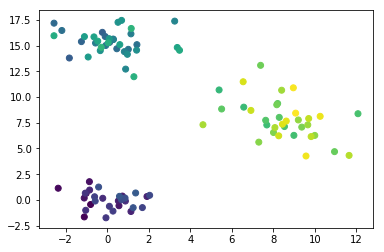

In [31]:
gctree.generate_clust_frame()
plt.scatter("Dim_0", "Dim_1", c = "clustnum", data=gctree.clustDF)
plt.show()